In [1]:
import warnings 
warnings.filterwarnings('ignore')

# ARMA sur Python

Afin de tester les méthodes ARMA sur python, j'ai pris un jeu de données que j'ai utilisé lors d'un challenge sur Kaggle. 

Ce concours m'a permis de tester et explorer différentes techniques de modèliser une série chronologiques. 

Les données fournis concernaient des ventes de 50 articles, sur 5 ans, dans différents magasins. On nous demandait de prédire les ventes des 3 prochains mois. 

## Lecture de nos données

In [2]:
import pandas as pd 

train = pd.read_csv('train.csv', parse_dates=['date'], index_col='date')
test = pd.read_csv('test.csv', parse_dates=['date'], index_col='date')
sample = pd.read_csv('sample_submission.csv')
                     
df = pd.concat([train,test],sort=True)

In [3]:
df.head()

,id,item,sales,store
date,,,,
2013-01-01,NaN,1,13.0,1
2013-01-02,NaN,1,11.0,1
2013-01-03,NaN,1,14.0,1
2013-01-04,NaN,1,13.0,1
2013-01-05,NaN,1,10.0,1


Ce jeu de données contient 4 colonnes donnant : 
- date : Date de la vente 
- store : l'ID du magasin 
- item : l'ID de l'article 
- sales : nombre de vente

La corrélation entre les variables du jeu de donnée est:

In [4]:
import matplotlib.pyplot as plt

df.corr().style.format("{:.3}").background_gradient(
    cmap=plt.get_cmap('coolwarm'))

,id,item,sales,store
id,1.0,1.0,nan,0.0199
item,1.0,1.0,-0.056,6.75e-15
sales,nan,-0.056,1.0,-0.00817
store,0.0199,6.75e-15,-0.00817,1.0


Il n'y pas de variable qui ont une forte corrélation.

## Visualisation des données 

Maintenant, nous allons voir la description statistique de ces variables : 

In [5]:
df.describe()

,id,item,sales,store
count,45000.000000,958000.000000,913000.000000,958000.000000
mean,22499.500000,25.500000,52.250287,5.500000
std,12990.525394,14.430877,28.801144,2.872283
min,0.000000,1.000000,0.000000,1.000000
25%,11249.750000,13.000000,30.000000,3.000000
50%,22499.500000,25.500000,47.000000,5.500000
75%,33749.250000,38.000000,70.000000,8.000000
max,44999.000000,50.000000,231.000000,10.000000


Il n'y a pas le même nombre de valeurs pour chaque variable. 

De plus, pour commencer, nous allons nous intéresser au magasin 1 et l'article 1. 

In [6]:
buf = df[(df.item==1)&(df.store==1)].copy()

Afin de visualiser nos données, nous allons utiliser <em>seasonal_decompose</em> qui permet de visualiser en 4 graphiques notre série temporelle : 
- observé 
- tendance 
- saisonnalité 
- résidus 

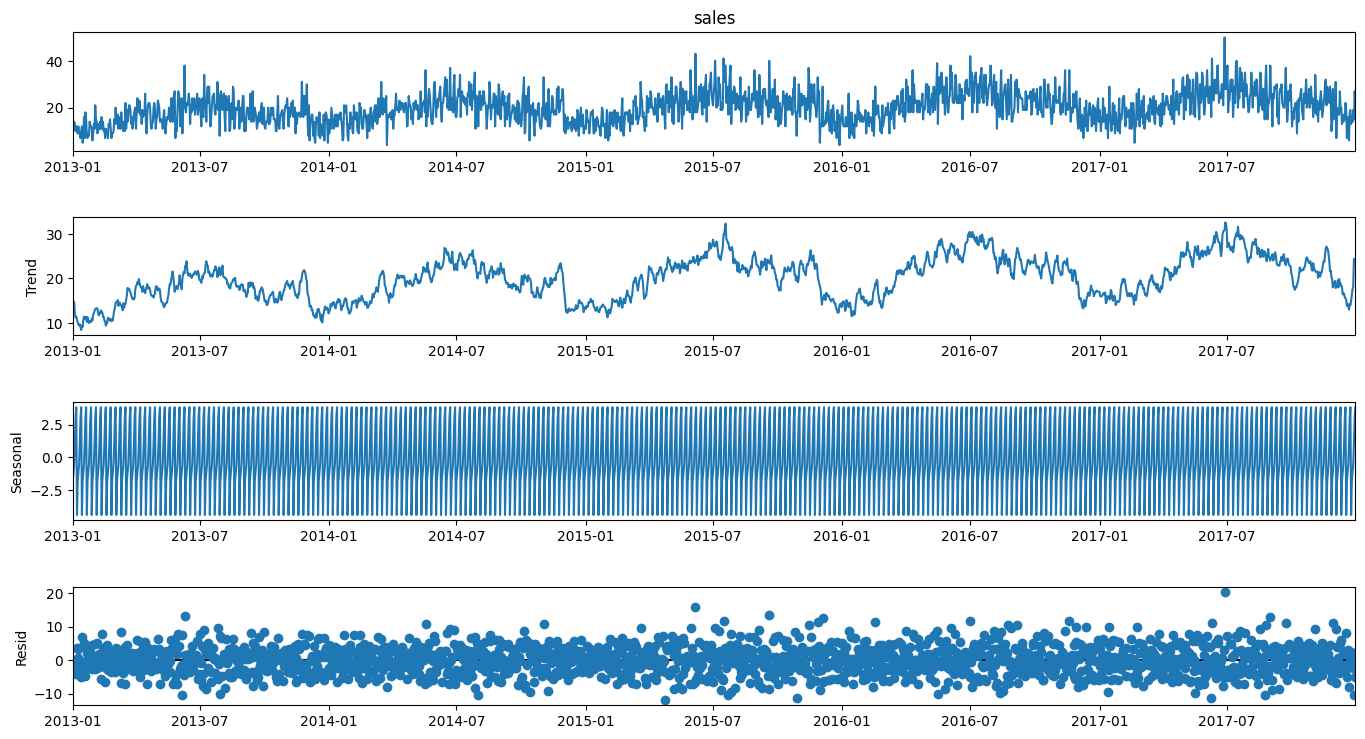

In [7]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(buf.sales.dropna(),extrapolate_trend=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

Nous avons choisi un extrapolate_trend de 365 car ce paramètre représente la fréquence sur un tendance en année. Et comme nous avons des données sur du long terme, il est préférable de l'utiliser. 

Si nous avons une tendance en mois, nous pouvons mettre 30 et si c'était en semaine, extrapolate_trend aurait eu la valeur 7. 

## Préparation des données 

Maintenant, nous devons séparer notre jeu de données en 2. 
- Train : les données 'Sales' sur lequel on va modéliser notre processus 
- Test : les données 'Sales' avec lesquels nous allons valider notre modèle (donc les 3 derniers mois)

Et nous enlevons les données manquantes. 

In [8]:
train = buf['sales']['2014-01-01':'2017-09-30'].dropna()
test = buf['sales']['2017-01-01':'2017-03-31'].dropna()

In [9]:
train.head()

date
2014-01-01     9.0
2014-01-02    14.0
2014-01-03    11.0
2014-01-04    20.0
2014-01-05    17.0
Name: sales, dtype: float64

# Choix du modèle

Sur python, il est possible de faire différents modèles où différents paramètres sont demandés : 
- ARMA(p,q)
- ARIMA(p,d,q)
- SARIMA(p,d,q)(sp,sd,sq,s)
- ARIMAX(p,d,q) + exog
- SARIMAX(p,d,q)(sp,sd,sq,s) +exog

Avec :
- autorégressive d’ordre p
- moyenne mobile d'ordre q 
- différenciation de tendance d'ordre d
- différenciation de saisonnalité d'ordre s 
    - sp : polynôme AR saisonnier 
    - sq : polynôme MA saisonnier
    - sd : polynôme de tendance saisonnier 
- exog : tableau de variables exogènes (si on veut une prévision hos échantillon)

## Test de stationnarité

Nous utilisons le test ADF (vu dans le cours) afin de vérifier si nos données sont stationnaires ou non. 

Pour cela, on utilise la fonction adfuller de la librarie statsmodels. 

Pour le paramètre de régression, nous pouvons choisir entre : 
- c : constante 
- ct : constante et tendance 
- ctt : constance et tendance linéaire et quadratique  
- nc : pas de constante ni de tendance

Nous avons besoin de deux variables pour comparer nos résultats : 
- toutes nos valeurs de Sales 
- nos différences de valeurs (différence entre valeur n et valeur n-1 [n : ligne])

In [10]:
x = buf['sales'].dropna() #toutes nos données

In [11]:
x_diff = buf['sales'].diff().dropna() #diffrence de toutes nos données

On essaie, en prenant une constante et tendance : 

In [12]:
res = sm.tsa.adfuller(x,regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.07610688992414712


Puis uniquement avec une constante si nous prenons en compte le processus de différenciation : 

In [13]:
res = sm.tsa.adfuller(x_diff,regression='c')
print('p-value:{}'.format(res[1]))

p-value:1.2109276320441508e-23


D'après les résultats, les données ne sont pas stationnaires. Il faut donc utiliser un processus ARIMA/SARIMA et il faut utiliser nos données différenciés (<em>train.diff())</em>.

In [14]:
x_train = train.diff().dropna()

## Estimation des paramètres 

Avec la fonction <em>arma_order_select_ic</em>, il est possible de chercher les meilleurs paramètres (p,q) d'un modèle ARMA. 

In [15]:
warnings.filterwarnings('ignore')

resDiff = sm.tsa.arma_order_select_ic(train, max_ar=10, max_ma=10, ic=['aic','bic'], trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (8, 7) is the best.


Nous pouvons donc dire que p = 8 et q = 7. 

Il est possible de confirmer le résultat de p et trouver le paramètre d en regardant l'autocorrélation et la fonction de l'autocorrélation. 

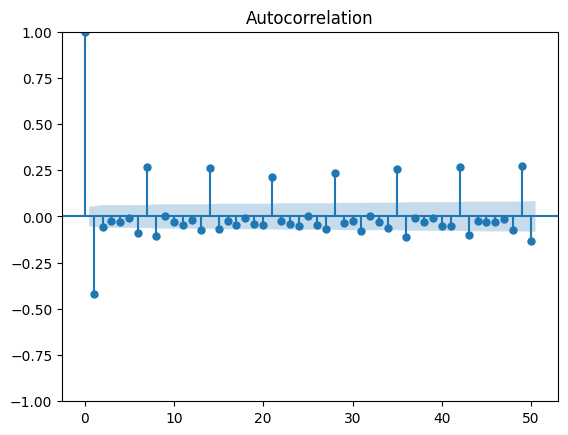

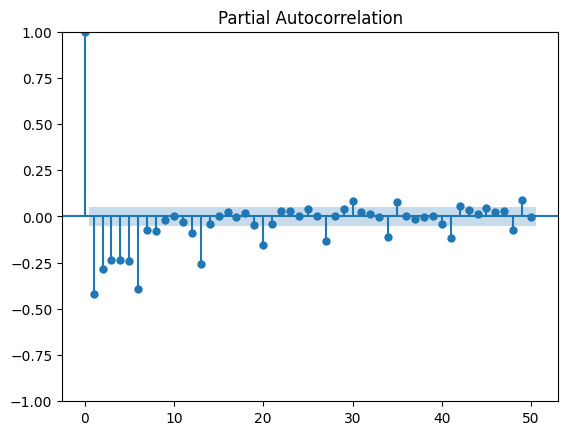

In [16]:
sm.graphics.tsa.plot_acf(x_train, lags=50)
sm.graphics.tsa.plot_pacf(x_train, lags=50)
plt.show()

D'après les graphiques, la valeur de p semble être autour de 7 et celle de d de 1. 

# Modèle ARIMA

Nous pouvons exécuter le modèle ARIMA afin la fonction <em>statespace.SARIMAX</em> de python. 

Nous indiquons les paramètres trouver juste au dessus dans "order". 

In [17]:
arima = sm.tsa.statespace.SARIMAX(train,
                                  # paramètres :
                                  order=(8,1,7),
                                  # paramètres de saisonnalité (il y en n' pas)
                                  seasonal_order=(0,0,0,0),
                                  # pas transformer AR pour rendre stationnaire
                                  enforce_stationarity=False, 
                                  # pas imposer inversibilité dans MA 
                                  enforce_invertibility=False,).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1369
Model:               SARIMAX(8, 1, 7)   Log Likelihood               -4073.796
Date:                Tue, 06 Dec 2022   AIC                           8179.592
Time:                        19:12:55   BIC                           8263.036
Sample:                    01-01-2014   HQIC                          8210.831
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8515      0.062    -13.638      0.000      -0.974      -0.729
ar.L2         -1.0009      0.051    -19.455      0.000      -1.102      -0.900
ar.L3         -0.9687      0.057    -17.027      0.000      -1.080      -0.857
ar.L4         -0.9632      0.057    -16.951      0.000      -1.075      -0.852
ar.L5         -1.0057      0.051    -19.830      0.000      -1.105      -0.906
ar.L6         -0.9349      0.062    -15.162      0.000      -1.056      -0.814
ar.L7         -0.0191      0.049     -0.393      0.695      -0.115       0.076
ar.L8         -0.0857      0.036     -2.363      0.018      -0.157      -0.015
ma.L1         -0.0524      0.069     -0.756      0.450      -0.188       0.083
ma.L2          0.2194      0.105      2.099      0.036       0.014       0.424
ma.L3          0.0408      0.088      0.464      0.643      -0.132       0.213
ma.L4          0.0917      0.074      1.239      0.215      -0.053       0.237
ma.L5          0.1759      0.097      1.815      0.070      -0.014       0.366
ma.L6         -0.0232      0.058     -0.401      0.689      -0.137       0.090
ma.L7         -0.7443      0.097     -7.694      0.000      -0.934      -0.555
sigma2        25.0703      2.945      8.514      0.000      19.299      30.842
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 8.26
Prob(Q):                              0.70   Prob(JB):                         0.02
Heteroskedasticity (H):               1.32   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Les résidus de ce de modèle ont quelques autocorrélations. C'est donc un bon modèle. 

Nous pouvons le visualiser : 

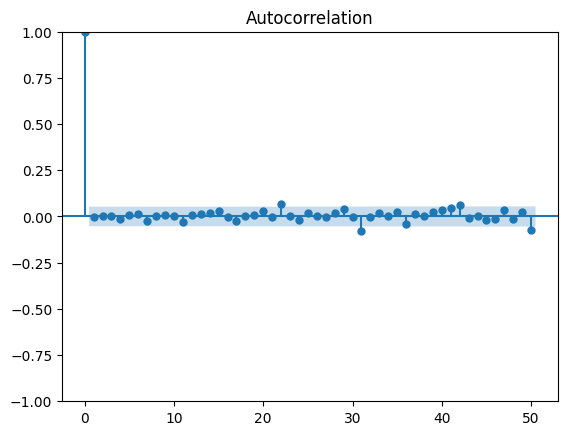

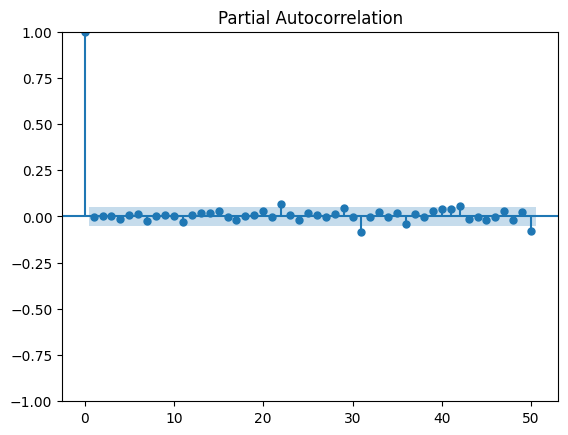

In [18]:
arima_res = arima.resid
fig = sm.graphics.tsa.plot_acf(arima_res, lags=50)
fig = sm.graphics.tsa.plot_pacf(arima_res, lags=50)
plt.show()

Nous pouvons visualiser notre prédiction : 

<AxesSubplot: >

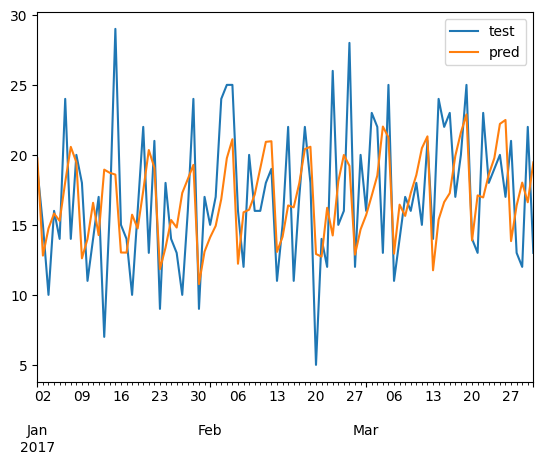

In [19]:
# entre fin du jeu train et jeu test
arima_pred = arima.predict('2016-12-31','2017-03-31')[1:]
pd.DataFrame({'test':test,'pred':arima_pred}).plot()

On remarque que nous avons une assez bonne prédiction. 

# Modèle SARIMA

Nous pouvons exécuter le modèle SARIMA afin la fonction <em>statespace.SARIMAX</em> de python. 

Nous indiquons les paramètres trouver dans "order". 

Concernant la saisonnalité, nous reprenons les mêmes paramètres pour les polynômes de AR, de MA, de tendance. 

Et la saisonnalité à une différenciation d'ordre 365 car nous avons une saisonnalité par nombre de jours dans l'année. En effet nos données sont données par jour. 

Donc pour un modèle SARIMA, nous rajoutons : <em>seasonal_order=(8,1,7,12)</em>

Avec, nous pouvons appliquer les mêmes fonctions.

# Modèles avec variables exogènes 

Avant de créer nos modèles il ne faut trouver des variables exogènes que l'on pourra utiliser lors de notre modélisation.

In [20]:
buf = df[(df.item==1)&(df.store==1)].copy()#reset buf
#month one hot encoding
buf['month'] = buf.index.month
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
buf = pd.concat([buf, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
buf['dayofweek'] = buf.index.weekday
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
buf = pd.concat([buf, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#Satday,Sunday
buf['weekend'] = (buf.index.dayofweek>4).astype(int)#Satday,Sunday
#Sunday
#buf['sunday'] = (buf.index.dayofweek==6).astype(int)#Satday,Sunday

#shifted data
#buf['sales_shifted_91'] = buf.sales.shift(91)
buf['sales_shifted_728'] = buf.sales.shift(728)
buf['sales_shifted_364'] = buf.sales.shift(364)
buf['outlier_flag']=0
buf.loc[buf.index == '2017-06-28','outlier_flag']=1

In [21]:
train_start, train_end = '2015-01-01','2017-09-30'
test_start, test_end = '2017-10-01','2017-12-31'
train_eg = buf['sales'][train_start:train_end].dropna()
test_eg = buf['sales'][test_start:test_end].dropna()
exog_train = buf.drop(['id','store','item','sales'],axis = 1)[train_start:train_end].dropna()
exog_test = buf.drop(['id','store','item','sales'],axis = 1)[test_start:test_end].dropna()

## ARIMAX

In [22]:
arimax = sm.tsa.statespace.SARIMAX(train_eg,
                                   order=(8,1,7),
                                   exog = exog_train,
                                   enforce_stationarity=False, 
                                   enforce_invertibility=False,).fit()
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1004
Model:               SARIMAX(8, 1, 7)   Log Likelihood               -2954.269
Date:                Tue, 06 Dec 2022   AIC                           5986.539
Time:                        19:13:05   BIC                           6177.746
Sample:                    01-01-2015   HQIC                          6059.229
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1              -3.4207   9695.269     -0.000      1.000    -1.9e+04     1.9e+04
month-2              -3.4018   9695.252     -0.000      1.000    -1.9e+04     1.9e+04
month-3              -2.3537   9695.222     -0.000      1.000    -1.9e+04     1.9e+04
month-4               0.0695   9695.241   7.17e-06      1.000    -1.9e+04     1.9e+04
month-5              -0.5269   9695.246  -5.43e-05      1.000    -1.9e+04     1.9e+04
month-6               1.0937   9695.259      0.000      1.000    -1.9e+04     1.9e+04
month-7               3.2954   9695.250      0.000      1.000    -1.9e+04     1.9e+04
month-8               1.2211   9695.255      0.000      1.000    -1.9e+04     1.9e+04
month-9               3.3061   9695.243      0.000      1.000    -1.9e+04     1.9e+04
month-10              3.4993   9695.245      0.000      1.000    -1.9e+04     1.9e+04
month-11              1.3699   9695.251      0.000      1.000    -1.9e+04     1.9e+04
month-12             -4.1519   9695.271     -0.000      1.000    -1.9e+04     1.9e+04
dayofweek-0          -3.7983   2.12e+04     -0.000      1.000   -4.15e+04    4.15e+04
dayofweek-1          -0.5883   2.12e+04  -2.78e-05      1.000   -4.15e+04    4.15e+04
dayofweek-2          -0.4545   2.12e+04  -2.15e-05      1.000   -4.15e+04    4.15e+04
dayofweek-3           0.2990   2.12e+04   1.41e-05      1.000   -4.15e+04    4.15e+04
dayofweek-4           1.8526   2.12e+04   8.76e-05      1.000   -4.15e+04    4.15e+04
dayofweek-5           0.9700   6961.446      0.000      1.000   -1.36e+04    1.36e+04
dayofweek-6           1.7193   6961.457      0.000      1.000   -1.36e+04    1.36e+04
weekend               2.6893   1.42e+04      0.000      1.000   -2.78e+04    2.78e+04
sales_shifted_728     0.0157      0.033      0.470      0.639      -0.050       0.081
sales_shifted_364     0.0639      0.032      1.985      0.047       0.001       0.127
outlier_flag         20.4248      7.628      2.678      0.007       5.475      35.375
ar.L1                -0.5569      0.582     -0.957      0.338      -1.697       0.583
ar.L2                -0.6243      0.368     -1.698      0.090      -1.345       0.096
ar.L3                -1.1732      0.390     -3.006      0.003      -1.938      -0.408
ar.L4                -0.4865      0.565     -0.861      0.389      -1.594       0.621
ar.L5                -0.6020      0.341     -1.767      0.077      -1.270       0.066
ar.L6                -0.3098      0.378     -0.821      0.412      -1.050       0.430
ar.L7                -0.1382      0.071     -1.939      0.053      -0.278       0.002
ar.L8                -0.0724      0.056     -1.286      0.199      -0.183       0.038
ma.L1                -0.6137      0.634     -0.968      0.333      -1.856       0.628
ma.L2                 0.3962      0.758      0.523      0.601      -1.089       1.881
ma.L3                 0.8373      0.797      1.051      0.293      -0.725       2.399
ma.L4                -0.7447      0.529     -1.409      0.1

Les résidus de ce de modèle ont quelques autocorrélations. C'est donc un bon modèle. 

Nous pouvons le visualiser : 

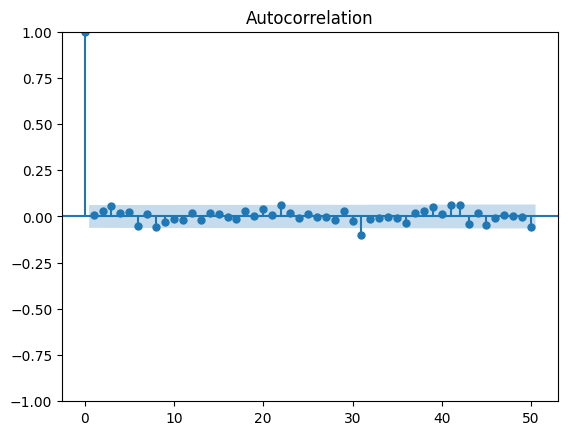

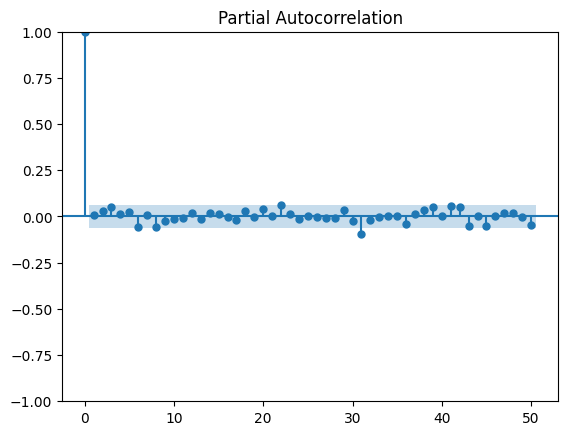

In [23]:
arimax_res = arimax.resid
fig = sm.graphics.tsa.plot_acf(arimax_res, lags=50)
fig = sm.graphics.tsa.plot_pacf(arimax_res, lags=50)

Nous pouvons visualiser notre prédiction :

<AxesSubplot: >

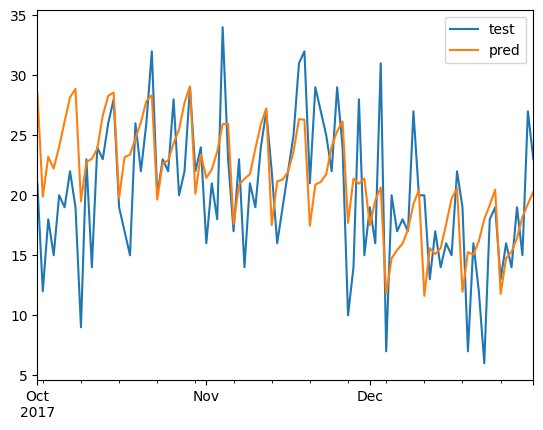

In [24]:
arimax_pred = arimax.predict(train_end,test_end,exog = exog_test)[1:]
pd.DataFrame({'test':test_eg,'pred':arimax_pred}).plot()

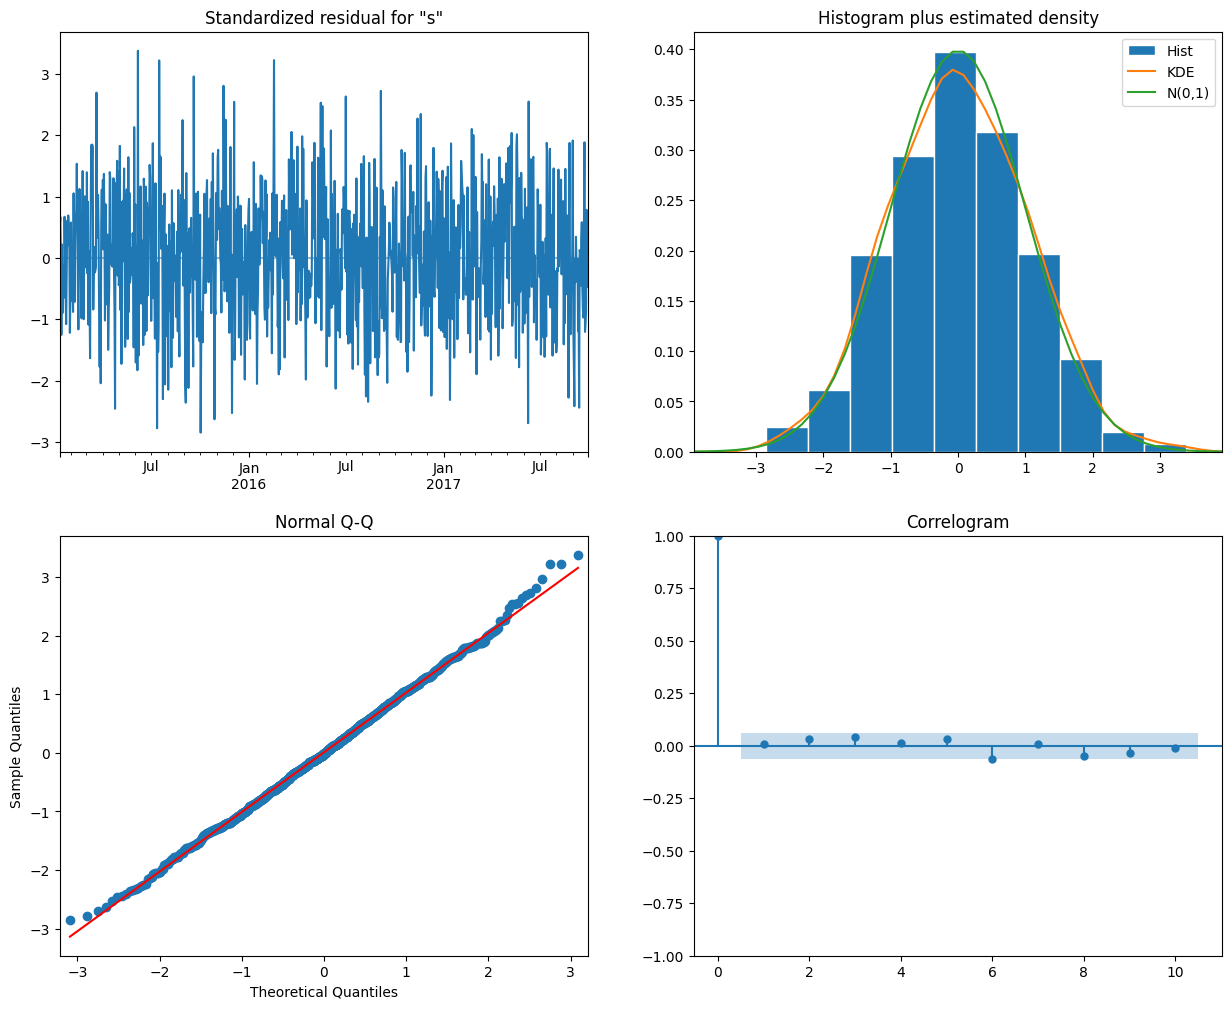

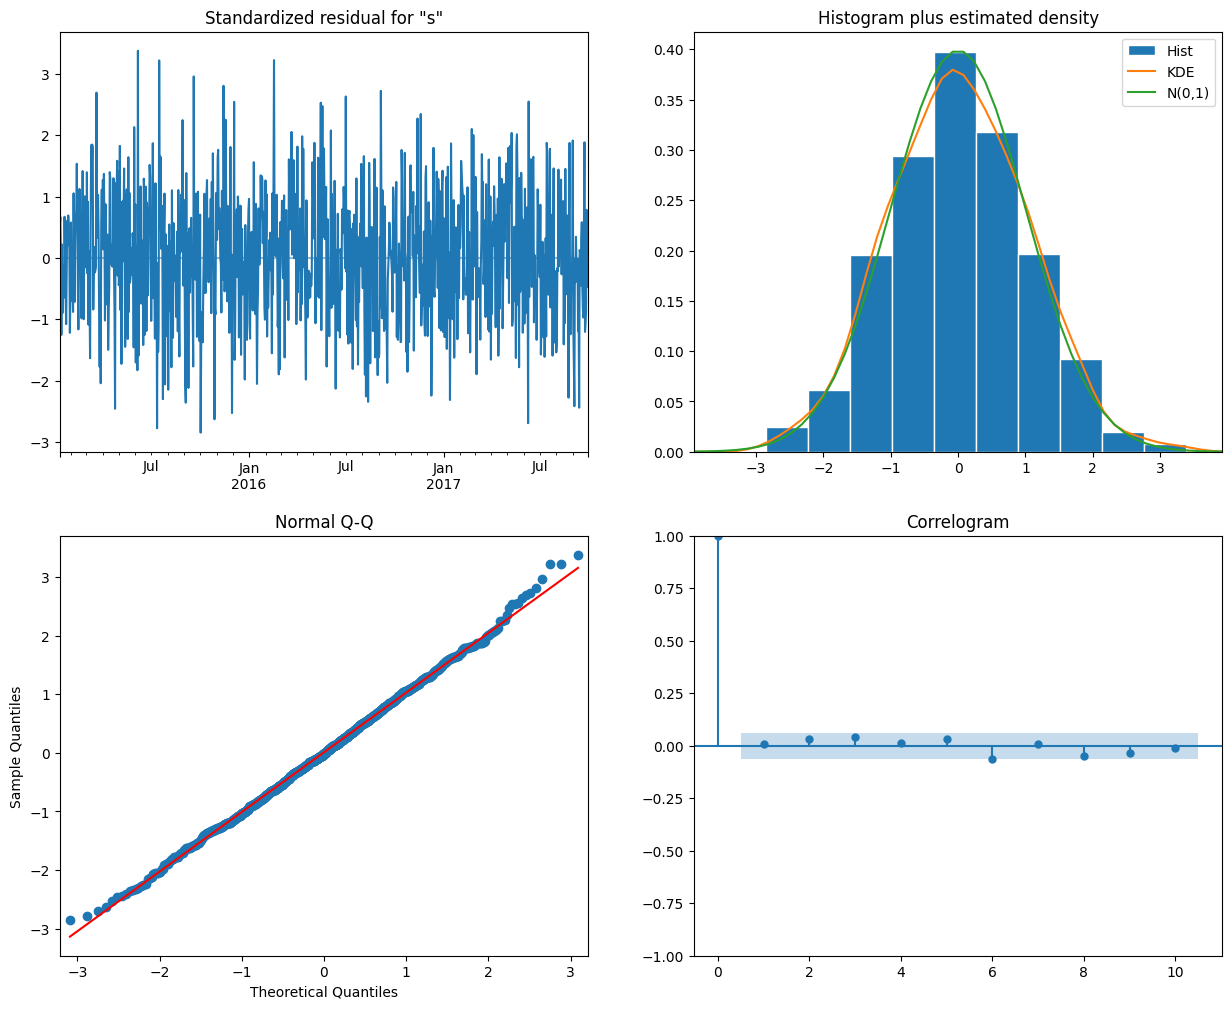

In [25]:
arimax.plot_diagnostics(figsize=(15, 12))

## SARIMAX

Une nouvelle fois, nous reprenons exactement le même code que lorsque nous lançons ARIMAX. Il faut simplement rajouter <em>seasonal_order=(8,1,7,12)</em> lorsque nous créons le modèle. 

Je ne l'ai pas éxecuté car cela prend trop de temps à s'exécuter à cause de la performance de mon ordinateur. 

# Validation du modèle

Pour valider notre modèle, nous faisons un test de blancheur tel que le test Ljung-Bix.

## ARIMAX

<AxesSubplot: xlabel='date'>

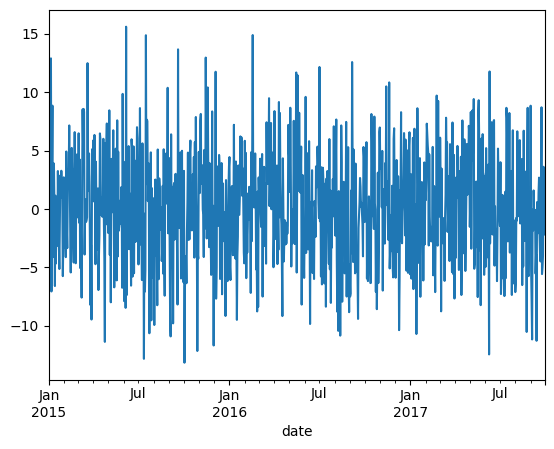

In [26]:
arimax.resid.plot()

Il semble qu'il y a aucune valeur abérrante.

# Qualité du modèle

In [27]:
from sklearn.metrics import mean_squared_error

## ARIMA

In [28]:
mean_squared_error(test,arima_pred)

20.723256416066178

## ARIMAX

In [29]:
mean_squared_error(test_eg,arimax_pred)

24.34129710521298

# Incertiture 

Nous allons prendre le modèle ARIMA pour faire une prédiction.

In [30]:
forecast = arima.get_forecast(steps=100)
forecast = forecast.summary_frame()
forecasts = pd.DataFrame(columns=["Prediction","Upper","Lower"])
forecasts["Prediction"] = forecast['mean']
forecasts["Upper"] = forecast['mean_ci_upper']
forecasts["Lower"] = forecast['mean_ci_lower']
forecasts.index = forecast.index

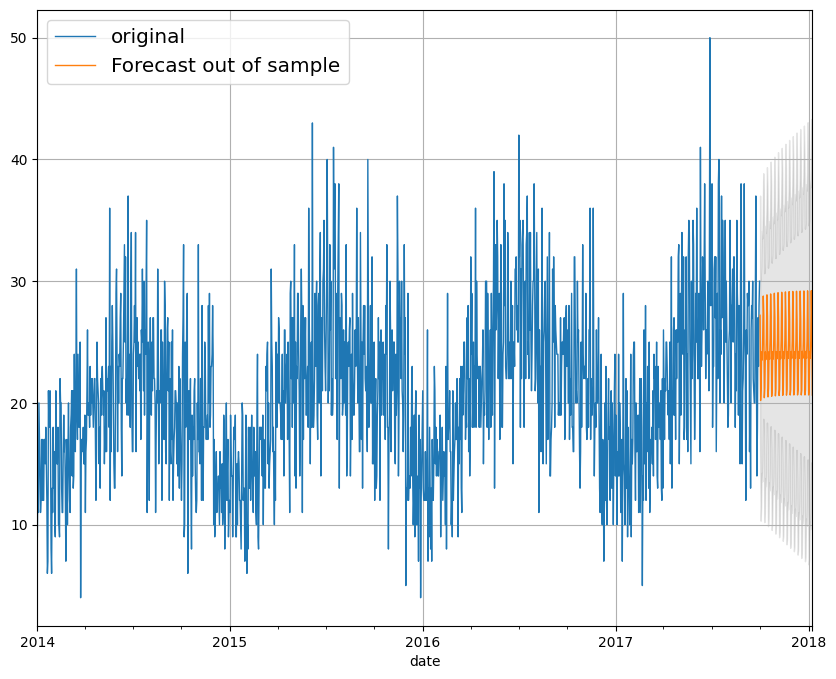

In [31]:
TempPred = forecasts.groupby(forecasts.index).mean()
fig, ax = plt.subplots(figsize=(10,8))
train.plot(linewidth=1, label='original')
TempPred["Prediction"].plot(linewidth=1, label='Forecast out of sample')
ax.fill_between(TempPred.index, TempPred['Lower'], TempPred['Upper'], color = 'k', alpha = 0.1)
plt.legend(fontsize='x-large')
plt.grid(True)